# Posterior uncertainties

In [1]:
import jax
import jax.numpy as jnp
import jax.random
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from odefilter import ivpsolve, recipes

config.update("jax_enable_x64", True)
backend.select("jax")

Set an example problem.

In [2]:
f, u0, (t0, t1), f_args = ivps.lotka_volterra()


@jax.jit
def vf(*ys, t, p):
    return f(*ys, *p)

## Filter

Low resolution and short time-span to achieve large uncertainty and only few steps.

In [3]:
ek0, info_op = recipes.ekf0_isotropic(num_derivatives=1)
ts = jnp.linspace(t0, t0 + 2.0, endpoint=True, num=500)

In [4]:
%%time

solution = ivpsolve.simulate_checkpoints(
    vf,
    initial_values=(u0,),
    ts=ts,
    solver=ek0,
    info_op=info_op,
    rtol=1e-1,
    atol=1e-1,
    parameters=f_args,
)

CPU times: user 1.1 s, sys: 3.62 ms, total: 1.11 s
Wall time: 1.09 s


Plot the solution

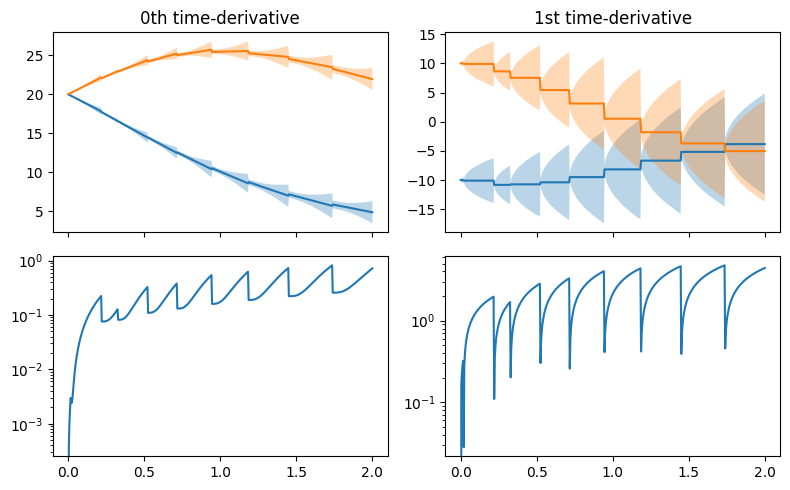

In [5]:
_, num_derivatives, _ = solution.marginals.mean.shape


fig, axes_all = plt.subplots(
    nrows=2,
    ncols=num_derivatives,
    sharex=True,
    tight_layout=True,
    figsize=(8, 5),
)

for i, axes_cols in enumerate(axes_all.T):
    ms = solution.marginals.mean[:, i, :]
    ls = solution.marginals.cov_sqrtm_lower[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    if i == 1:
        axes_cols[0].set_title(f"{i}st time-derivative")
    elif i == 2:
        axes_cols[0].set_title(f"{i}nd time-derivative")
    elif i == 3:
        axes_cols[0].set_title(f"{i}rd time-derivative")
    else:
        axes_cols[0].set_title(f"{i}th time-derivative")

    axes_cols[0].plot(solution.t, ms)
    for m in ms.T:
        axes_cols[0].fill_between(
            solution.t, m - 1.96 * stds, m + 1.96 * stds, alpha=0.3
        )

    axes_cols[1].semilogy(solution.t, stds)

plt.show()

## Smoother

In [6]:
ek0, info_op = recipes.eks0_isotropic_fixedpoint(num_derivatives=1)
ts = jnp.linspace(t0, t0 + 2.0, endpoint=True, num=500)

In [7]:
%%time

solution = ivpsolve.simulate_checkpoints(
    vf,
    initial_values=(u0,),
    ts=ts,
    solver=ek0,
    info_op=info_op,
    rtol=1e-1,
    atol=1e-1,
    parameters=f_args,
)

CPU times: user 1.74 s, sys: 17.7 ms, total: 1.76 s
Wall time: 1.73 s


In [8]:
key = jax.random.PRNGKey(seed=1)
u, samples = ek0.sample(key, solution=solution, shape=(2,))

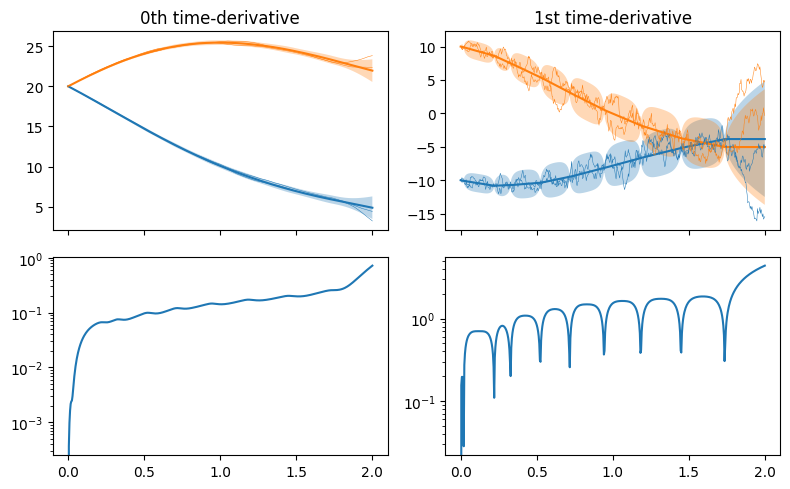

In [16]:
_, num_derivatives, _ = solution.marginals.mean.shape


fig, axes_all = plt.subplots(
    nrows=2,
    ncols=num_derivatives,
    sharex=True,
    tight_layout=True,
    figsize=(8, 5),
)

for i, axes_cols in enumerate(axes_all.T):
    ms = solution.marginals.mean[:, i, :]
    samps = samples[..., i, :]
    ls = solution.marginals.cov_sqrtm_lower[:, i, :]
    stds = jnp.sqrt(jnp.einsum("jn,jn->j", ls, ls))

    if i == 1:
        axes_cols[0].set_title(f"{i}st time-derivative")
    elif i == 2:
        axes_cols[0].set_title(f"{i}nd time-derivative")
    elif i == 3:
        axes_cols[0].set_title(f"{i}rd time-derivative")
    else:
        axes_cols[0].set_title(f"{i}th time-derivative")

    axes_cols[0].plot(solution.t, ms)
    for s in samps:
        axes_cols[0].plot(solution.t, s[..., 0], color="C0", linewidth=0.35)
        axes_cols[0].plot(solution.t, s[..., 1], color="C1", linewidth=0.35)
    for m in ms.T:
        axes_cols[0].fill_between(
            solution.t, m - 1.96 * stds, m + 1.96 * stds, alpha=0.3
        )

    axes_cols[1].semilogy(solution.t, stds)

plt.show()

The marginal standard deviations obviously show how the filter is forward-only, whereas the smoother is a global estimate.

This is why you should use a filter for terminal-value simulation and a smoother if you want "global" solutions.